
Ridge Performance:
  R^2 Score:           0.6632
  Mean Squared Error:  1538.5550
  Mean Absolute Error: 30.4129
  PHM08 Score (sum):   5254207.4706
  PHM08 Score (avg):   1273.1300

BayesianRidge Performance:
  R^2 Score:           0.6633
  Mean Squared Error:  1538.0894
  Mean Absolute Error: 30.4087
  PHM08 Score (sum):   5241313.9763
  PHM08 Score (avg):   1270.0058

Ensemble Performance:
  R^2 Score:           0.6633
  Mean Squared Error:  1538.3161
  Mean Absolute Error: 30.4107
  PHM08 Score (sum):   5247675.1215
  PHM08 Score (avg):   1271.5472
Plotting SHAP summary (Ridge)...


Plotting SHAP summary (BayesianRidge)...


Plotting SHAP summary (Ensemble)...


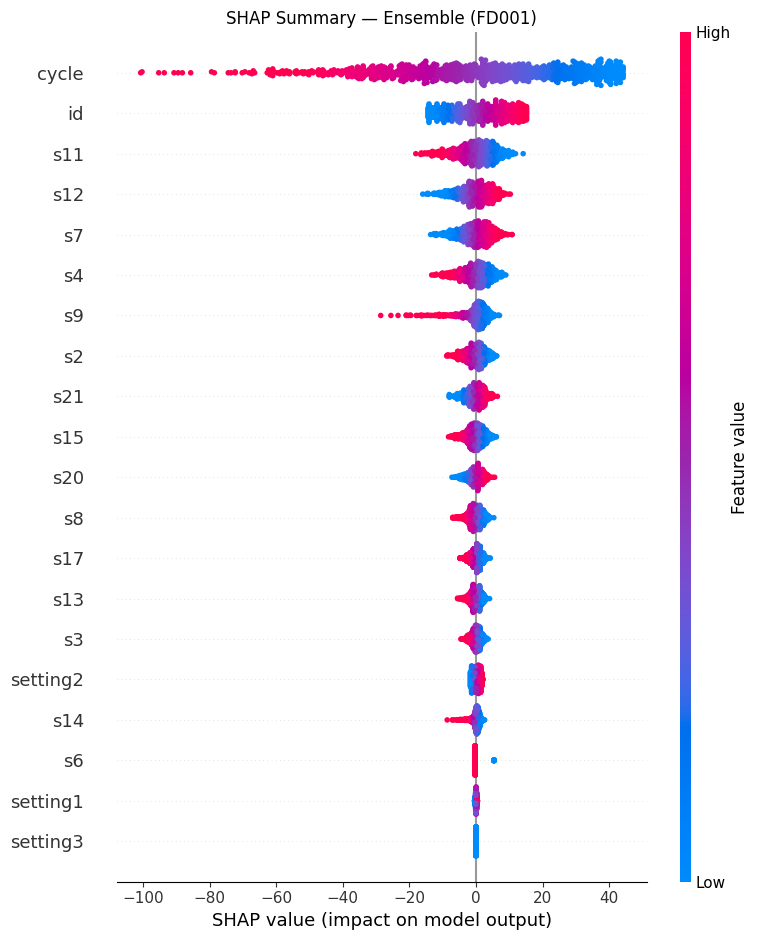

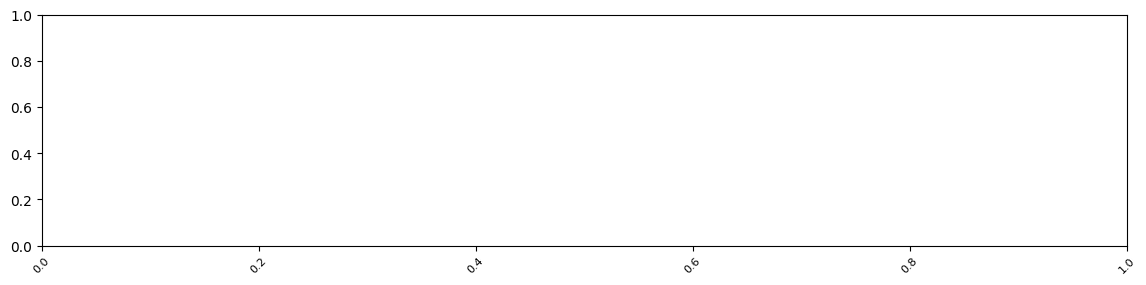

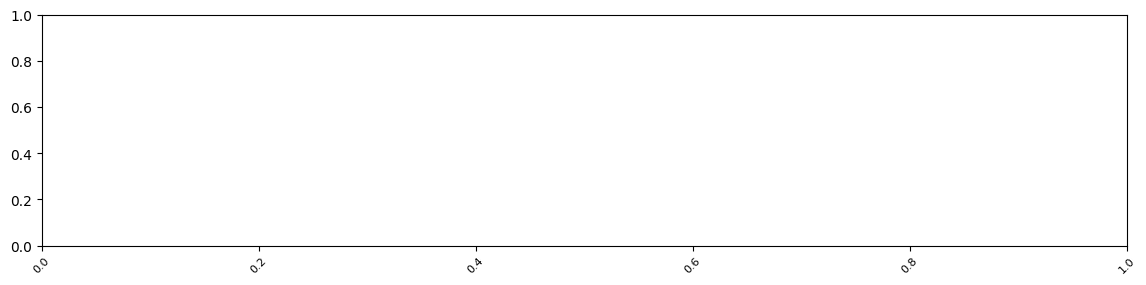

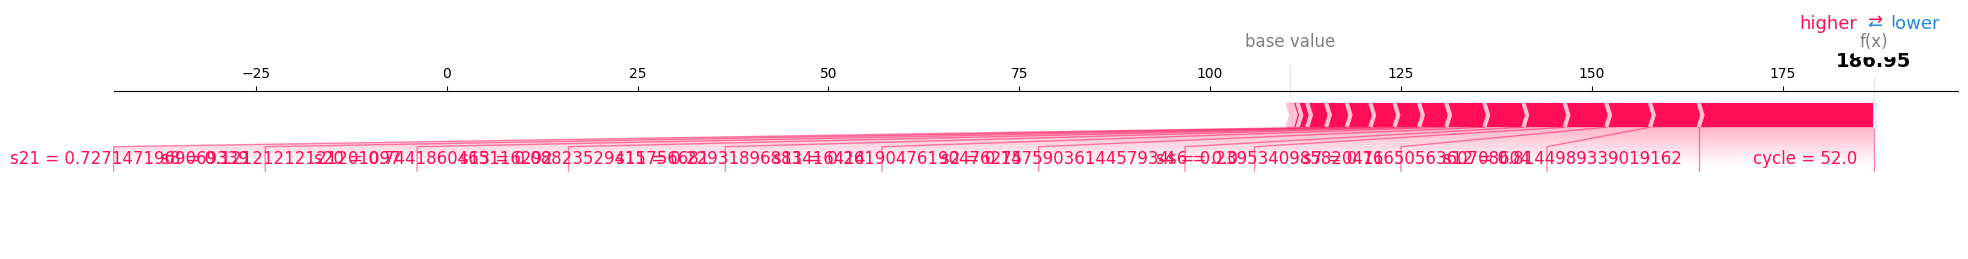

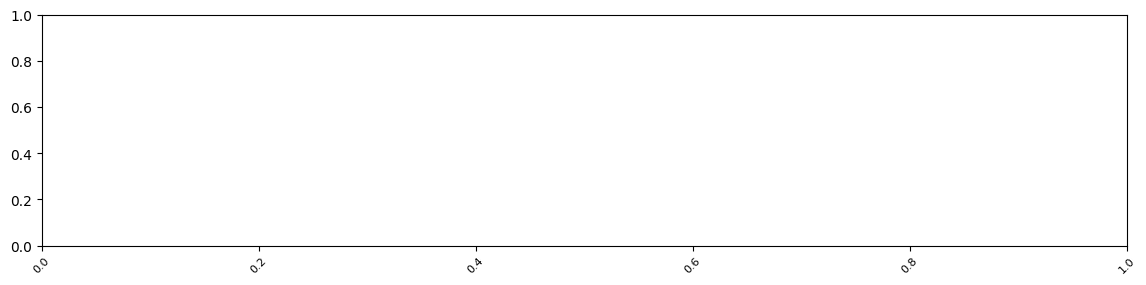

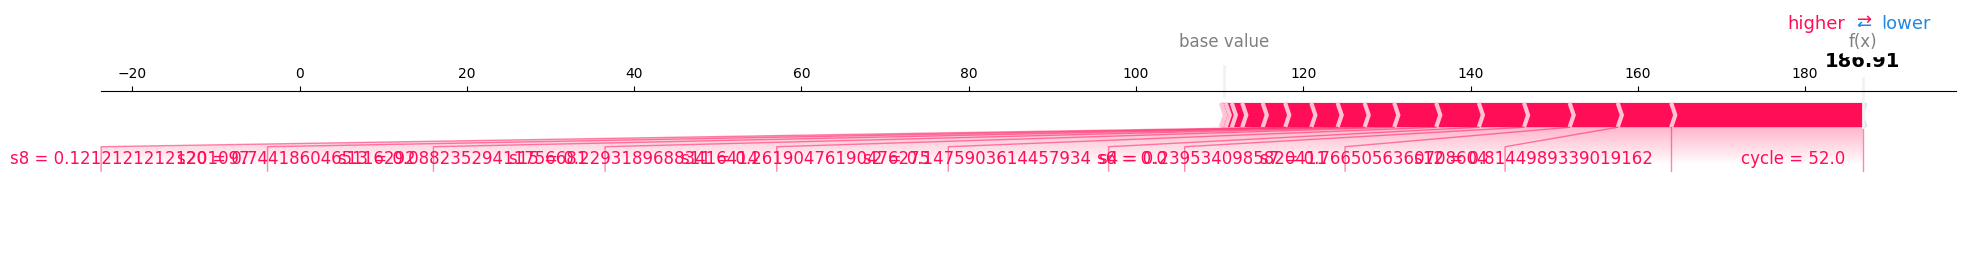

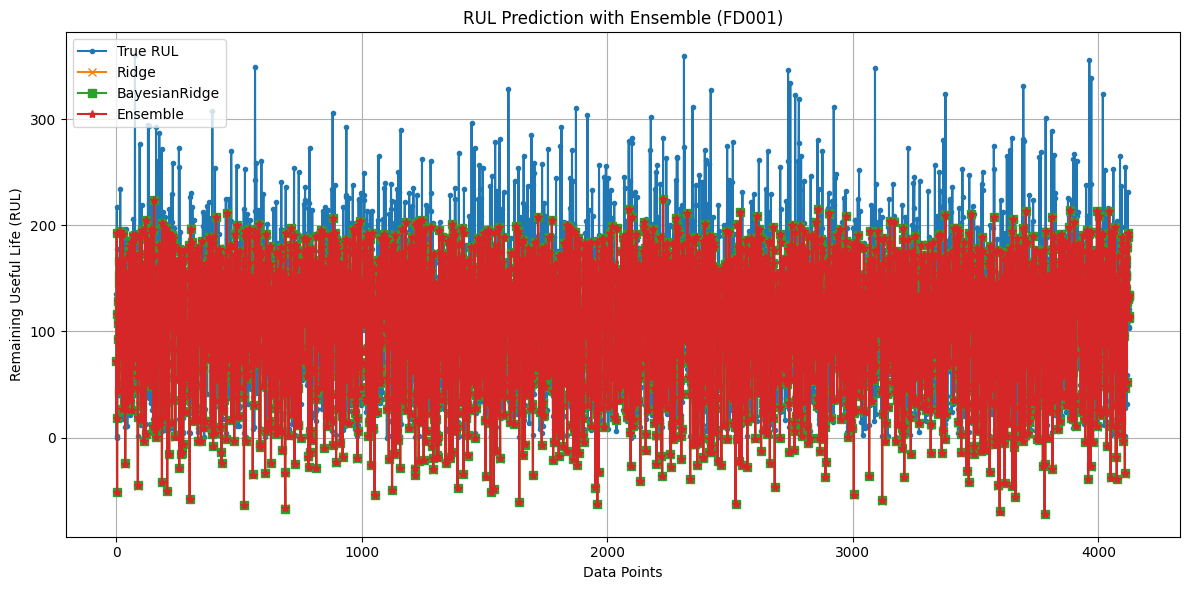



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (Ridge) ---
Fold1: R2=0.5755, RMSE=46.1239, MAE=35.2221, PHM08_sum=19156083.9883, PHM08_avg=4649.5349
Fold2: R2=0.6571, RMSE=40.5652, MAE=30.2987, PHM08_sum=4093243.9946, PHM08_avg=990.3808
Fold3: R2=0.7237, RMSE=36.2391, MAE=27.9818, PHM08_sum=1485637.3505, PHM08_avg=360.0672
Fold4: R2=0.6295, RMSE=41.3630, MAE=33.0326, PHM08_sum=1449492.7481, PHM08_avg=351.3922
Fold5: R2=0.6776, RMSE=38.2543, MAE=30.3394, PHM08_sum=923986.5133, PHM08_avg=223.8882
Overall: R2=0.6518, RMSE=40.6442, MAE=31.3733, PHM08_sum=27108444.5947, PHM08_avg=1313.9666

--- GroupKFold (BayesianRidge) ---
Fold1: R2=0.5755, RMSE=46.1247, MAE=35.2229, PHM08_sum=19147487.4604, PHM08_avg=4647.4484
Fold2: R2=0.6571, RMSE=40.5653, MAE=30.2987, PHM08_sum=4093484.2229, PHM08_avg=990.4390
Fold

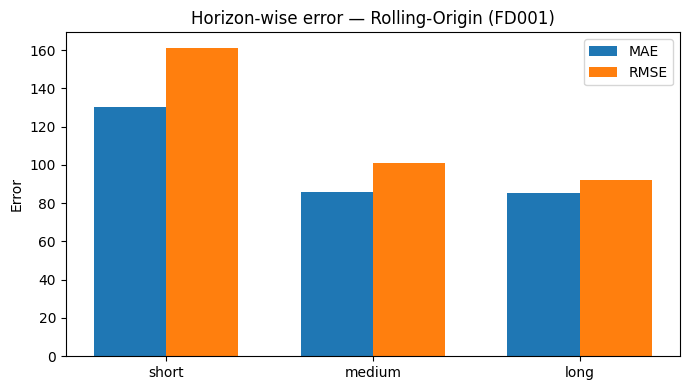

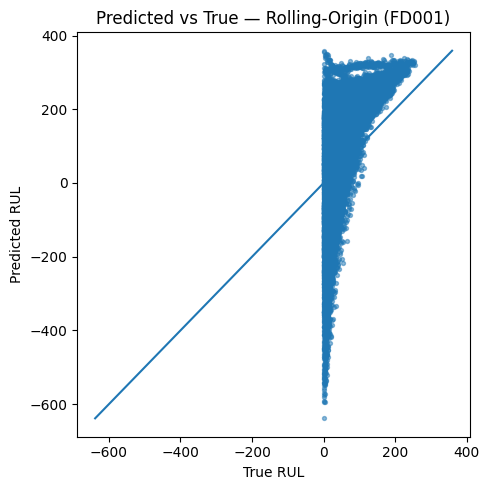


[PER-ENGINE MAE] (Top 10 worst engines)
94    149.633844
56    149.531042
92    147.175737
48    146.651115
97    140.572583
18    137.354277
25    136.552764
51    136.153715
54    135.405938
17    131.595102
dtype: float64


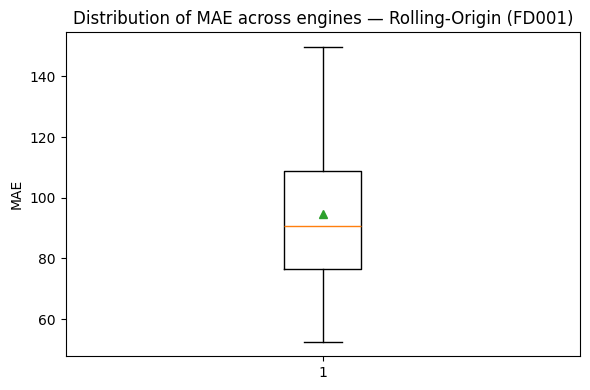

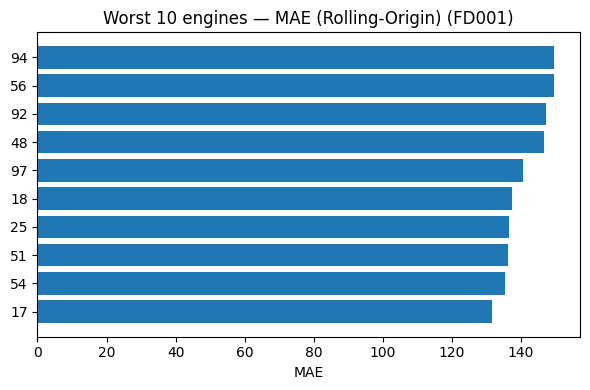


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -7.5835
    RMSE: 121.1613
     MAE: 99.6312
 sMAPE_%: 111.7633

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6527 ± 0.0494
Without id/cycle : R²=0.5777 ± 0.0442


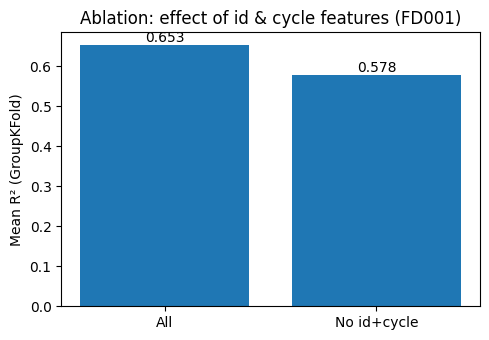


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 20631
Train (80%)   : 16504  → ratio=0.8000
Test  (20%)   : 4127  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 40.47 seconds
CPU% at start        : 20.7%   (~0.54 GHz)
CPU% at end          : 24.4%   (~0.63 GHz)
Memory at start      : 466.76 MB
Memory at end        : 458.51 MB   (Δ -8.25 MB)


In [4]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD001"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "ridgeregbayesridge"

# Fixed model hyperparameters (as requested)
RIDGE_PARAMS = dict(
    alpha=1.0,
    max_iter=1000,
    solver='auto',
    random_state=42
)

BAYES_PARAMS = dict(
    alpha_1=1e-6,
    alpha_2=1e-5,
    lambda_1=1e-4,
    lambda_2=1e-6,
    tol=1e-4
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.linear_model import Ridge, BayesianRidge

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (Ridge + BayesianRidge)
# ============================================
ridge_model = Ridge(**RIDGE_PARAMS)
ridge_model.fit(X_train, y_train)
y_ridge = ridge_model.predict(X_val)

bayes_model = BayesianRidge(**BAYES_PARAMS)
bayes_model.fit(X_train, y_train)
y_bayes = bayes_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_ridge + 0.5 * y_bayes

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_ridge = print_block_metrics("Ridge",        y_val, y_ridge)
m_bayes = print_block_metrics("BayesianRidge",y_val, y_bayes)
m_ens   = print_block_metrics("Ensemble",     y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_ridge, m_bayes, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (modern API for linear models)
# ============================================
import shap
from shap import maskers

n_samples = min(1000, X_val.shape[0])
X_shap = X_val.sample(n=n_samples, random_state=42)

# Build a masker from the training data (independent perturbation)
mask = maskers.Independent(X_train)

# Ridge SHAP
explainer_ridge = shap.LinearExplainer(ridge_model, mask)
ridge_exp = explainer_ridge(X_shap)          # Explanation object
shap_vals_ridge = ridge_exp.values           # (n_samples, n_features)
expected_ridge = np.atleast_1d(ridge_exp.base_values).mean()

print("Plotting SHAP summary (Ridge)...")
shap.summary_plot(shap_vals_ridge, X_shap, show=False)
plt.title(f"SHAP Summary — Ridge ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ridge_{DATASET_NAME}.png")
plt.show()

# BayesianRidge SHAP
explainer_bayes = shap.LinearExplainer(bayes_model, mask)
bayes_exp = explainer_bayes(X_shap)
shap_vals_bayes = bayes_exp.values
expected_bayes = np.atleast_1d(bayes_exp.base_values).mean()

print("Plotting SHAP summary (BayesianRidge)...")
shap.summary_plot(shap_vals_bayes, X_shap, show=False)
plt.title(f"SHAP Summary — BayesianRidge ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_BayesianRidge_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP (average the per-feature contributions)
shap_vals_ens = (shap_vals_ridge + shap_vals_bayes) / 2.0
print("Plotting SHAP summary (Ensemble)...")
shap.summary_plot(shap_vals_ens, X_shap, show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# ---------- Local (single-row) force plots ----------
row = X_shap.iloc[[0]]

ridge_row_exp = explainer_ridge(row)
sv_ridge_row  = ridge_row_exp.values[0]
base_ridge    = float(np.atleast_1d(ridge_row_exp.base_values)[0])

bayes_row_exp = explainer_bayes(row)
sv_bayes_row  = bayes_row_exp.values[0]
base_bayes    = float(np.atleast_1d(bayes_row_exp.base_values)[0])

sv_ens_row    = (sv_ridge_row + sv_bayes_row) / 2.0
base_ens      = (base_ridge + base_bayes) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_ridge, sv_ridge_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ridge_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_bayes, sv_bayes_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_BayesianRidge_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_ens, sv_ens_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_ridge)),    y_ridge,        label="Ridge",           marker='x')
plt.plot(range(len(y_bayes)),    y_bayes,        label="BayesianRidge",   marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",        marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_ridge = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", Ridge(**RIDGE_PARAMS))
])
pipe_bayes = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", BayesianRidge(**BAYES_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_ridge, name="Ridge")
_ = cv_eval_pipeline(X, y, groups, pipe_bayes, name="BayesianRidge")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_ridge():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])

def build_pipe_bayes():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", BayesianRidge(**BAYES_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge, name="Ridge"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_bayes, name="BayesianRidge"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_ridge, name="Ridge")
_ = cv_eval_pipeline(X, y, groups, build_pipe_ridge(), name="Ridge (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge,
    embargo_val=0,  name=f"Rolling-Origin Ridge (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge,
    embargo_val=10, name=f"Rolling-Origin Ridge (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_ridge)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_ridge)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



Ridge Performance:
  R^2 Score:           0.6448
  Mean Squared Error:  1666.9473
  Mean Absolute Error: 31.7774
  PHM08 Score (sum):   21041771.8782
  PHM08 Score (avg):   1957.0100

BayesianRidge Performance:
  R^2 Score:           0.6478
  Mean Squared Error:  1652.8516
  Mean Absolute Error: 31.6123
  PHM08 Score (sum):   21465182.1505
  PHM08 Score (avg):   1996.3897

Ensemble Performance:
  R^2 Score:           0.6470
  Mean Squared Error:  1656.6619
  Mean Absolute Error: 31.6645
  PHM08 Score (sum):   21143319.0459
  PHM08 Score (avg):   1966.4545
Plotting SHAP summary (Ridge)...


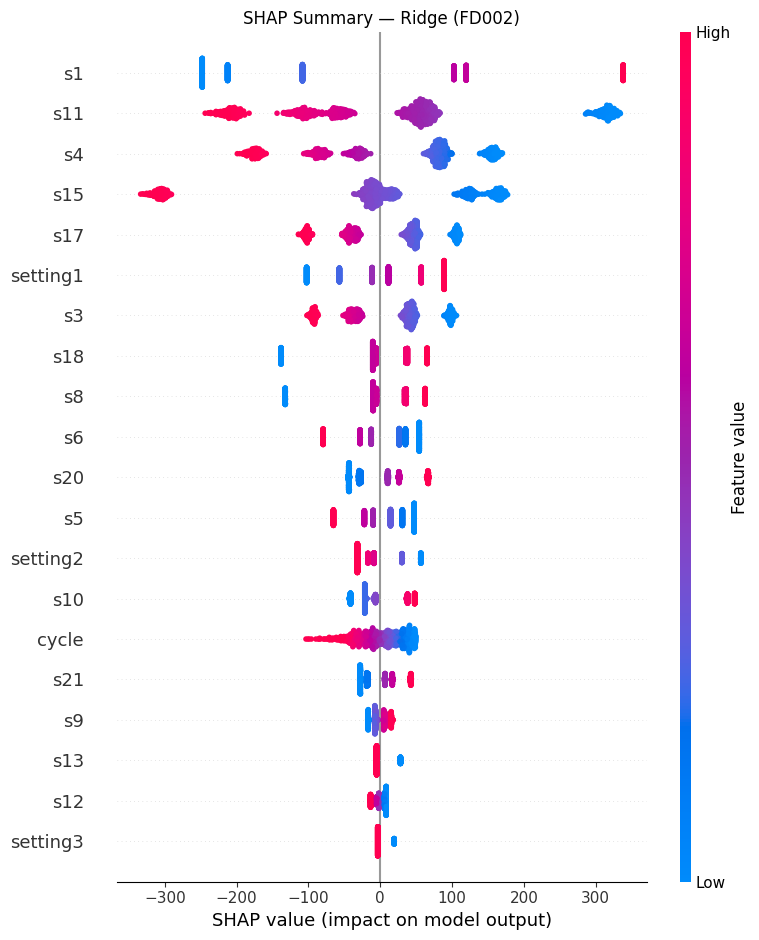

Plotting SHAP summary (BayesianRidge)...


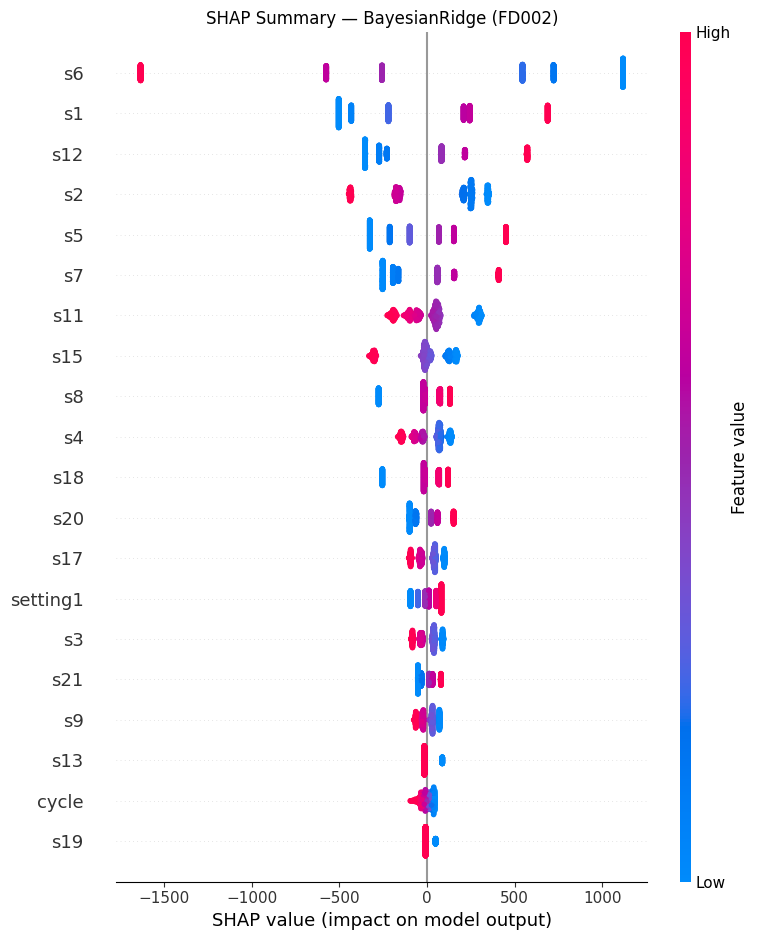

Plotting SHAP summary (Ensemble)...


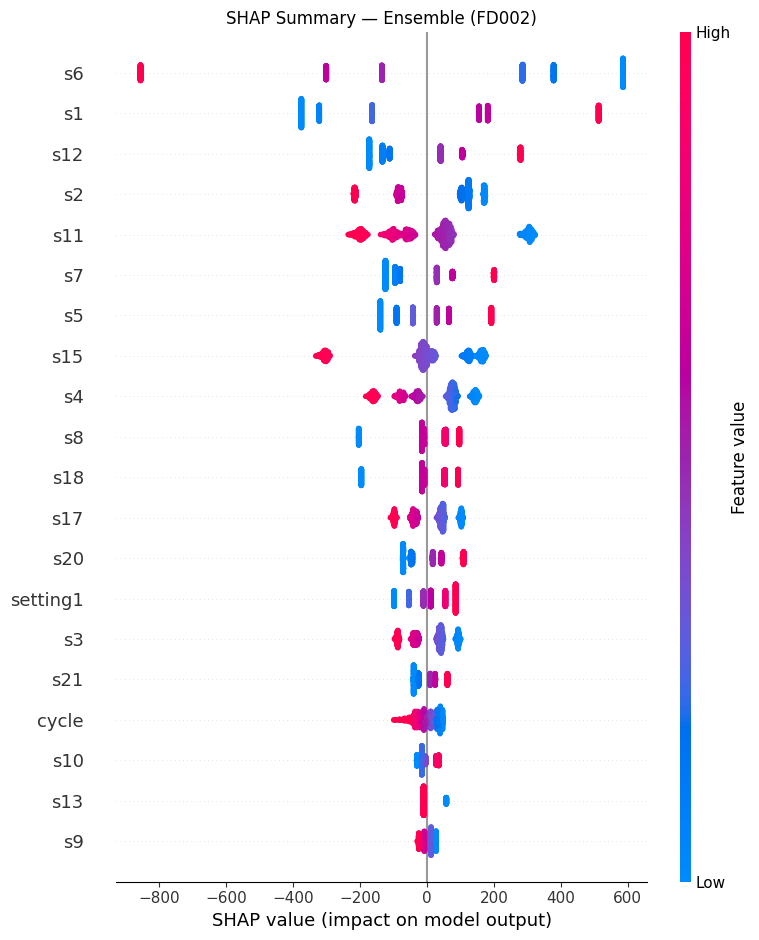

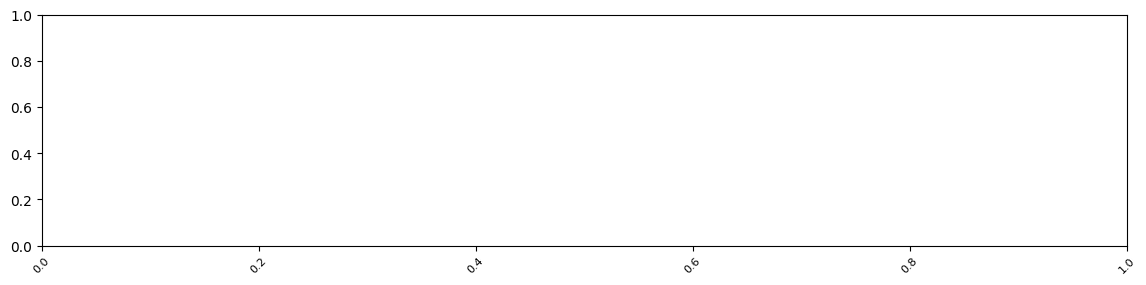

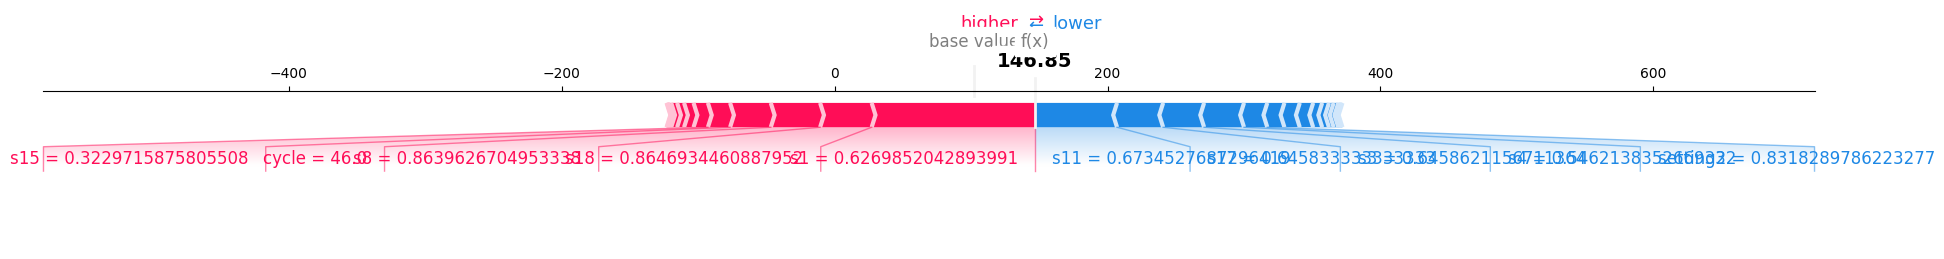

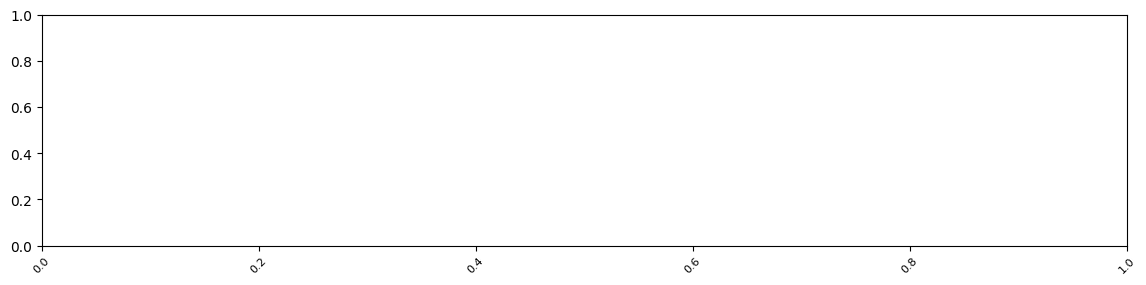

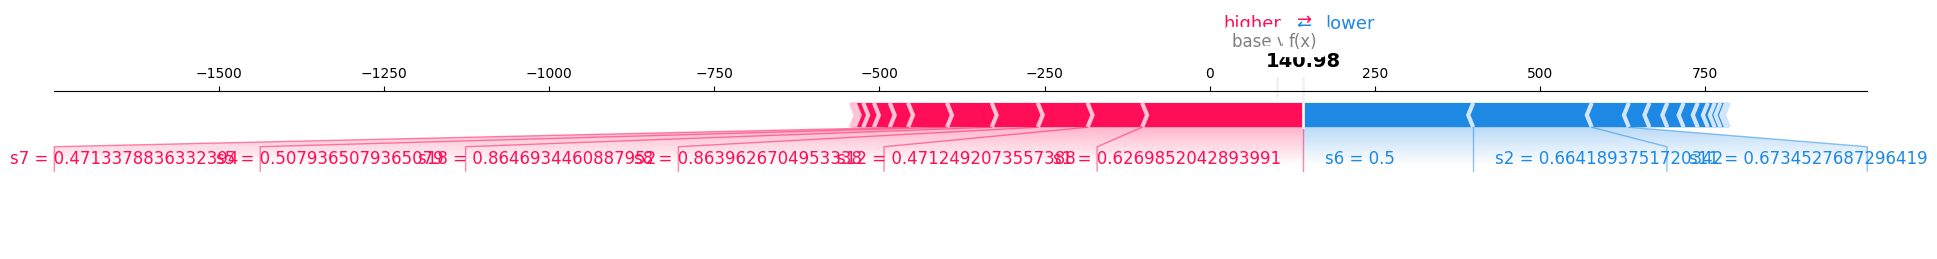

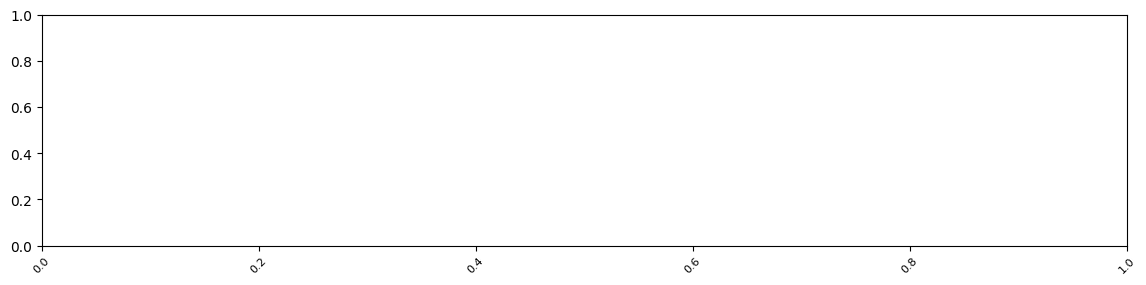

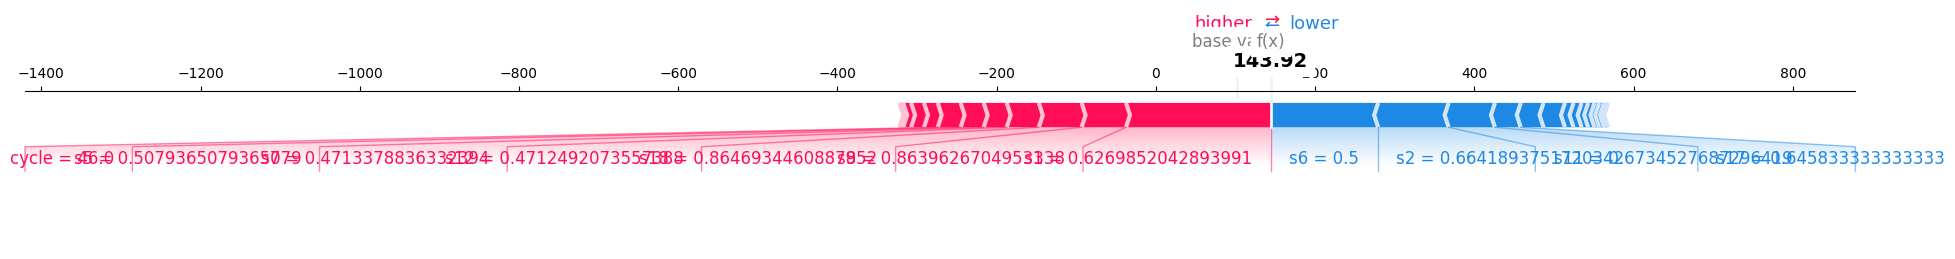

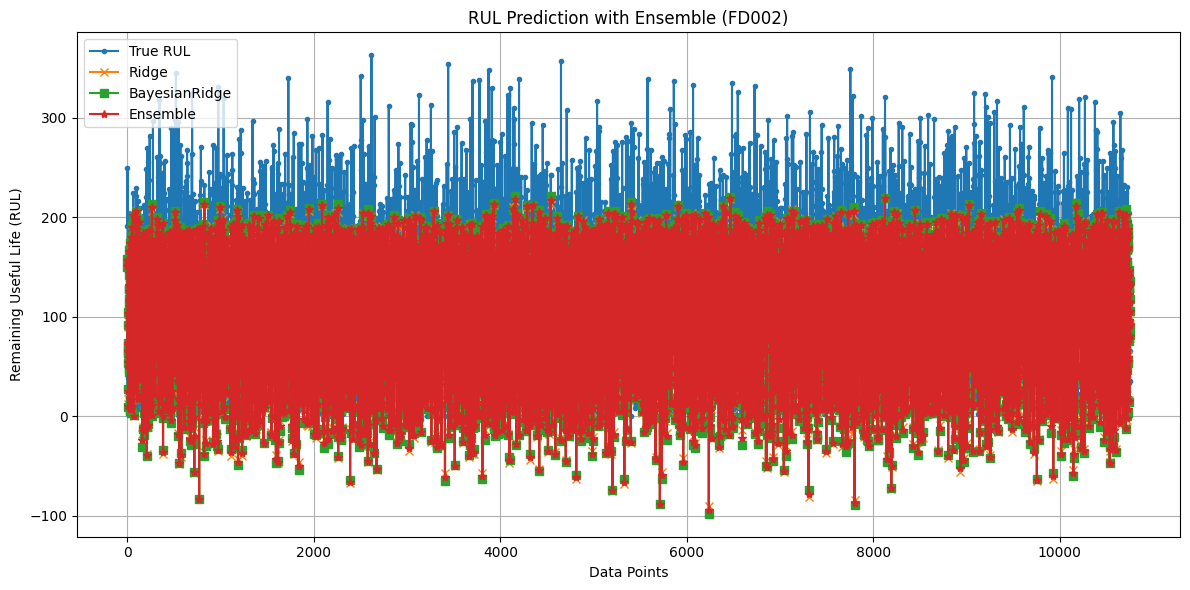



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (Ridge) ---
Fold1: R2=0.6262, RMSE=42.5470, MAE=32.7751, PHM08_sum=54965382.3626, PHM08_avg=5110.6818
Fold2: R2=0.6575, RMSE=40.5535, MAE=31.8989, PHM08_sum=11611193.7305, PHM08_avg=1080.2115
Fold3: R2=0.6416, RMSE=41.2520, MAE=30.8982, PHM08_sum=51347235.9220, PHM08_avg=4775.1545
Fold4: R2=0.6647, RMSE=39.9071, MAE=31.4210, PHM08_sum=6562068.4849, PHM08_avg=610.2547
Fold5: R2=0.6354, RMSE=41.7697, MAE=32.7966, PHM08_sum=12457833.5556, PHM08_avg=1158.9760
Overall: R2=0.6450, RMSE=41.2162, MAE=31.9579, PHM08_sum=136943714.0557, PHM08_avg=2547.3635

--- GroupKFold (BayesianRidge) ---
Fold1: R2=0.6295, RMSE=42.3608, MAE=32.6524, PHM08_sum=52627535.0898, PHM08_avg=4893.3087
Fold2: R2=0.6642, RMSE=40.1588, MAE=31.5466, PHM08_sum=10075063.5976, PHM08_avg=937.

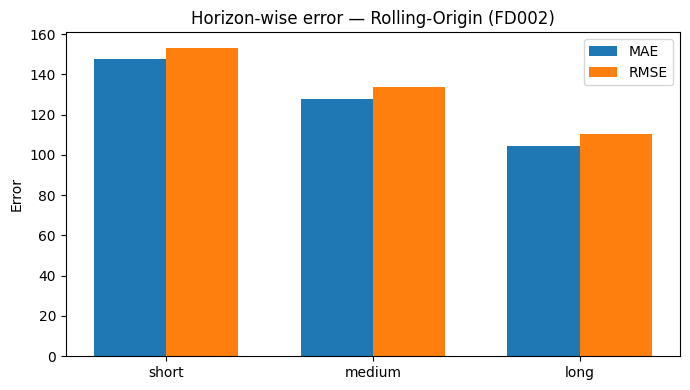

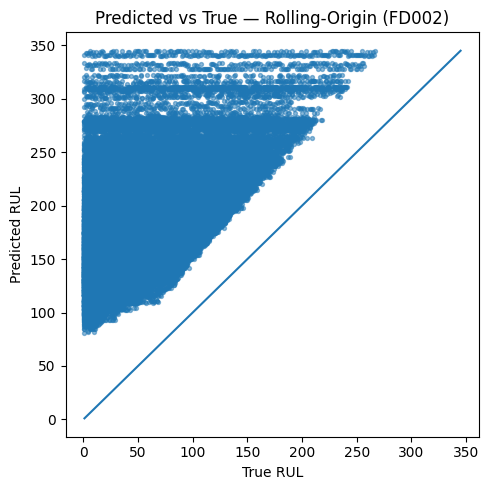


[PER-ENGINE MAE] (Top 10 worst engines)
112    204.818528
88     198.025476
85     190.019682
118    187.714263
255    187.336406
31     186.470823
158    171.177629
128    167.744666
260    167.639968
94     166.900139
dtype: float64


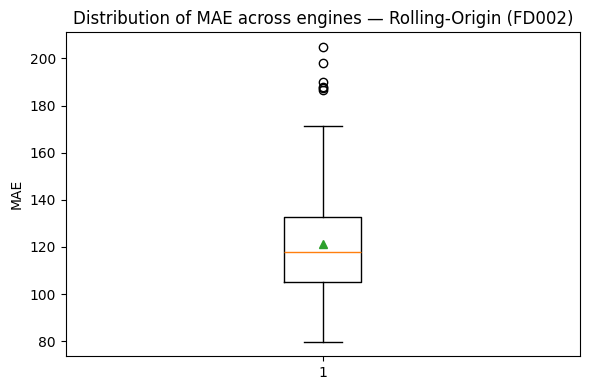

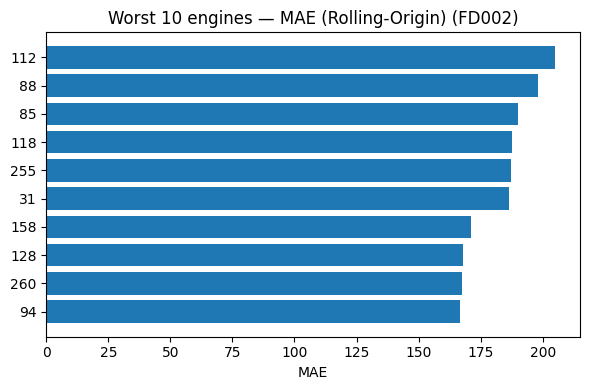


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -9.4823
    RMSE: 134.5925
     MAE: 127.8421
 sMAPE_%: 118.3057

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6451 ± 0.0141
Without id/cycle : R²=0.5660 ± 0.0242


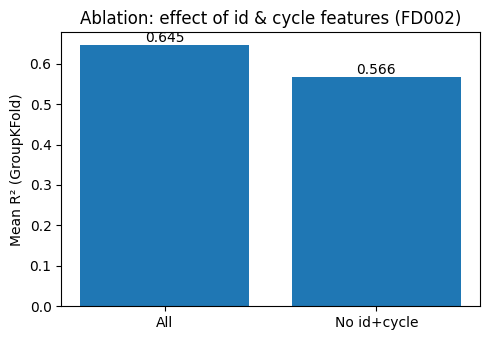


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 53759
Train (80%)   : 43007  → ratio=0.8000
Test  (20%)   : 10752  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 89.48 seconds
CPU% at start        : 16.7%   (~0.43 GHz)
CPU% at end          : 19.3%   (~0.50 GHz)
Memory at start      : 458.77 MB
Memory at end        : 574.68 MB   (Δ 115.91 MB)


In [5]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD002"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "ridgeregbayesridge"

# Fixed model hyperparameters (as requested)
RIDGE_PARAMS = dict(
    alpha=1.0,
    max_iter=1000,
    solver='auto',
    random_state=42
)

BAYES_PARAMS = dict(
    alpha_1=1e-6,
    alpha_2=1e-5,
    lambda_1=1e-4,
    lambda_2=1e-6,
    tol=1e-4
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.linear_model import Ridge, BayesianRidge

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (Ridge + BayesianRidge)
# ============================================
ridge_model = Ridge(**RIDGE_PARAMS)
ridge_model.fit(X_train, y_train)
y_ridge = ridge_model.predict(X_val)

bayes_model = BayesianRidge(**BAYES_PARAMS)
bayes_model.fit(X_train, y_train)
y_bayes = bayes_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_ridge + 0.5 * y_bayes

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_ridge = print_block_metrics("Ridge",        y_val, y_ridge)
m_bayes = print_block_metrics("BayesianRidge",y_val, y_bayes)
m_ens   = print_block_metrics("Ensemble",     y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_ridge, m_bayes, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (modern API for linear models)
# ============================================
import shap
from shap import maskers

n_samples = min(1000, X_val.shape[0])
X_shap = X_val.sample(n=n_samples, random_state=42)

# Build a masker from the training data (independent perturbation)
mask = maskers.Independent(X_train)

# Ridge SHAP
explainer_ridge = shap.LinearExplainer(ridge_model, mask)
ridge_exp = explainer_ridge(X_shap)          # Explanation object
shap_vals_ridge = ridge_exp.values           # (n_samples, n_features)
expected_ridge = np.atleast_1d(ridge_exp.base_values).mean()

print("Plotting SHAP summary (Ridge)...")
shap.summary_plot(shap_vals_ridge, X_shap, show=False)
plt.title(f"SHAP Summary — Ridge ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ridge_{DATASET_NAME}.png")
plt.show()

# BayesianRidge SHAP
explainer_bayes = shap.LinearExplainer(bayes_model, mask)
bayes_exp = explainer_bayes(X_shap)
shap_vals_bayes = bayes_exp.values
expected_bayes = np.atleast_1d(bayes_exp.base_values).mean()

print("Plotting SHAP summary (BayesianRidge)...")
shap.summary_plot(shap_vals_bayes, X_shap, show=False)
plt.title(f"SHAP Summary — BayesianRidge ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_BayesianRidge_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP (average the per-feature contributions)
shap_vals_ens = (shap_vals_ridge + shap_vals_bayes) / 2.0
print("Plotting SHAP summary (Ensemble)...")
shap.summary_plot(shap_vals_ens, X_shap, show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# ---------- Local (single-row) force plots ----------
row = X_shap.iloc[[0]]

ridge_row_exp = explainer_ridge(row)
sv_ridge_row  = ridge_row_exp.values[0]
base_ridge    = float(np.atleast_1d(ridge_row_exp.base_values)[0])

bayes_row_exp = explainer_bayes(row)
sv_bayes_row  = bayes_row_exp.values[0]
base_bayes    = float(np.atleast_1d(bayes_row_exp.base_values)[0])

sv_ens_row    = (sv_ridge_row + sv_bayes_row) / 2.0
base_ens      = (base_ridge + base_bayes) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_ridge, sv_ridge_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ridge_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_bayes, sv_bayes_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_BayesianRidge_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_ens, sv_ens_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_ridge)),    y_ridge,        label="Ridge",           marker='x')
plt.plot(range(len(y_bayes)),    y_bayes,        label="BayesianRidge",   marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",        marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_ridge = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", Ridge(**RIDGE_PARAMS))
])
pipe_bayes = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", BayesianRidge(**BAYES_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_ridge, name="Ridge")
_ = cv_eval_pipeline(X, y, groups, pipe_bayes, name="BayesianRidge")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_ridge():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])

def build_pipe_bayes():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", BayesianRidge(**BAYES_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge, name="Ridge"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_bayes, name="BayesianRidge"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_ridge, name="Ridge")
_ = cv_eval_pipeline(X, y, groups, build_pipe_ridge(), name="Ridge (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge,
    embargo_val=0,  name=f"Rolling-Origin Ridge (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge,
    embargo_val=10, name=f"Rolling-Origin Ridge (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_ridge)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_ridge)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



Ridge Performance:
  R^2 Score:           0.6251
  Mean Squared Error:  3674.3666
  Mean Absolute Error: 44.8512
  PHM08 Score (sum):   1631419911300.5730
  PHM08 Score (avg):   329979755.5220

BayesianRidge Performance:
  R^2 Score:           0.6251
  Mean Squared Error:  3674.3726
  Mean Absolute Error: 44.8509
  PHM08 Score (sum):   1647823459082.0457
  PHM08 Score (avg):   333297625.2189

Ensemble Performance:
  R^2 Score:           0.6251
  Mean Squared Error:  3674.3695
  Mean Absolute Error: 44.8510
  PHM08 Score (sum):   1639601100801.3154
  PHM08 Score (avg):   331634526.8611
Plotting SHAP summary (Ridge)...


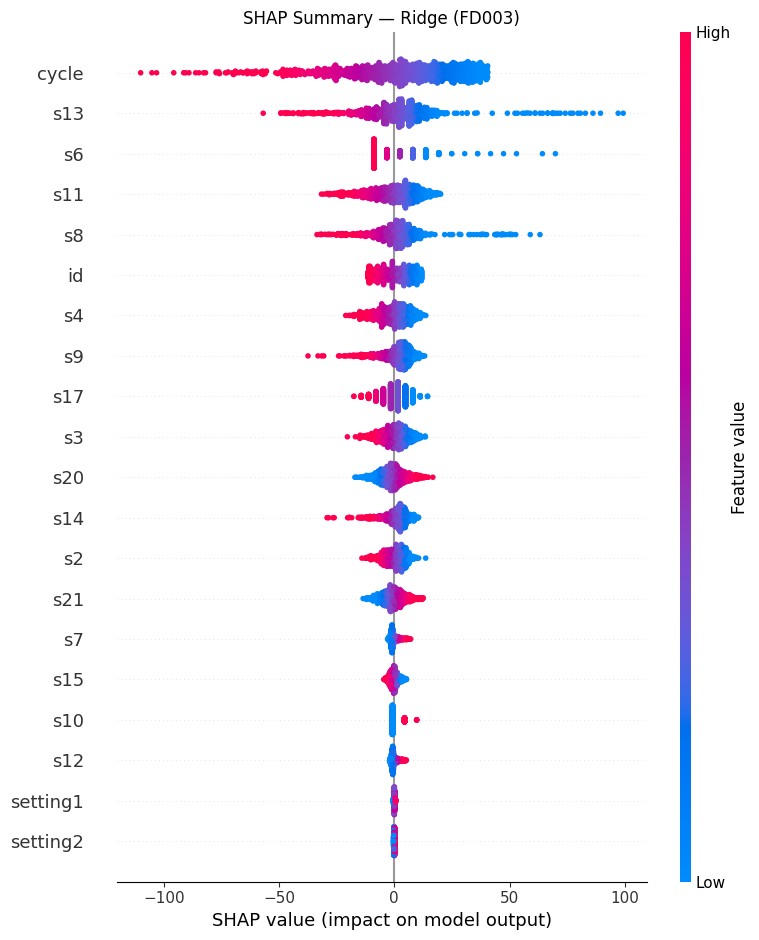

Plotting SHAP summary (BayesianRidge)...


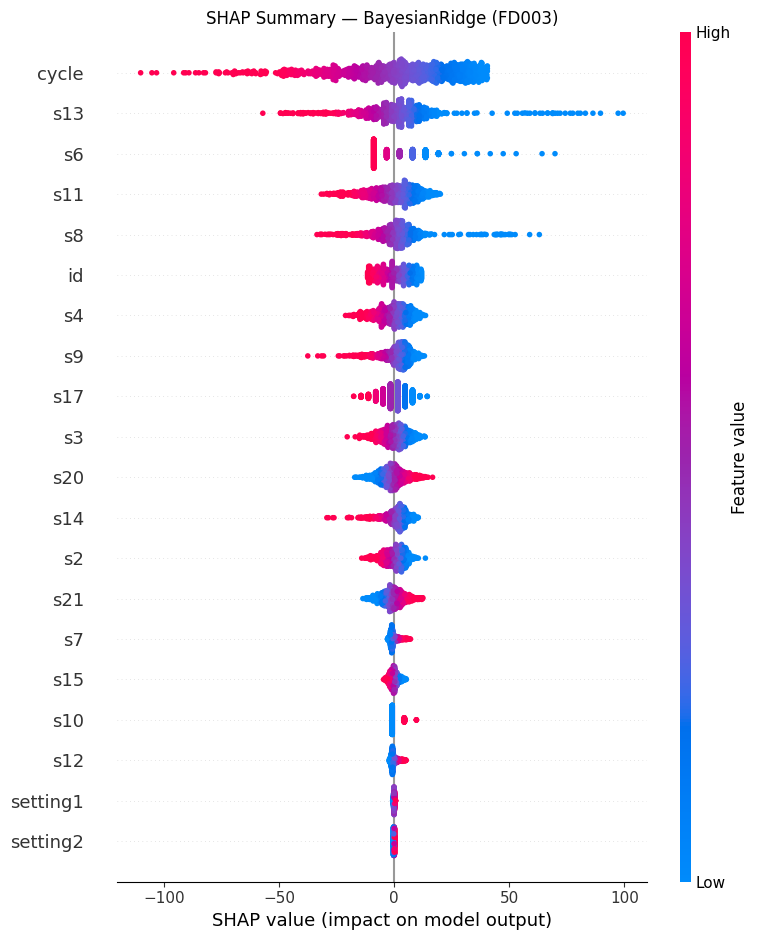

Plotting SHAP summary (Ensemble)...


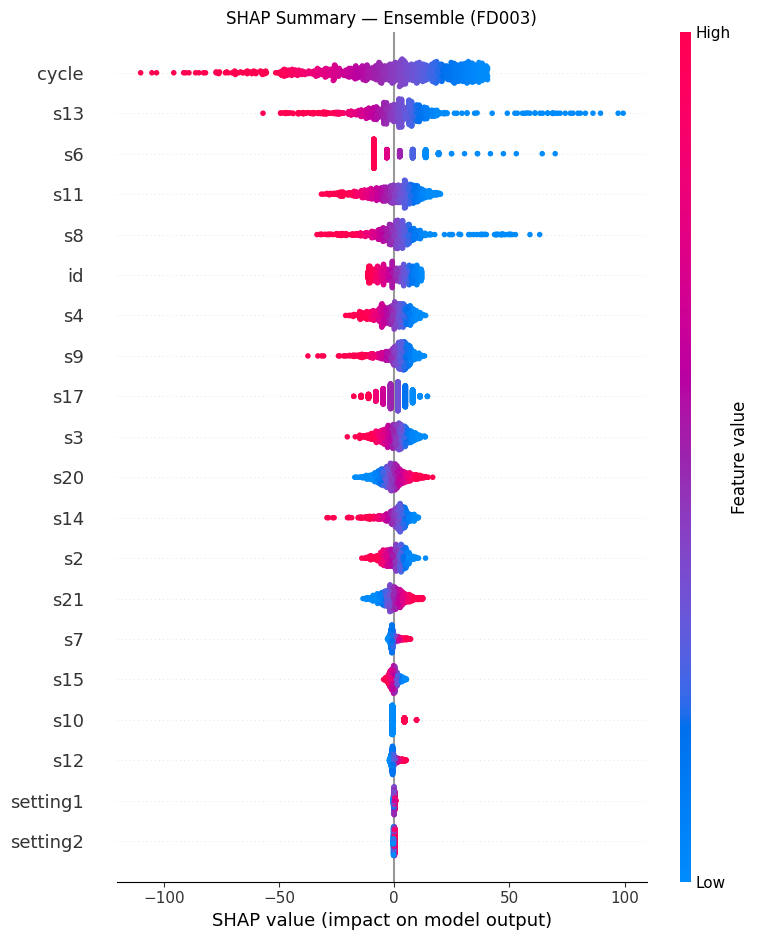

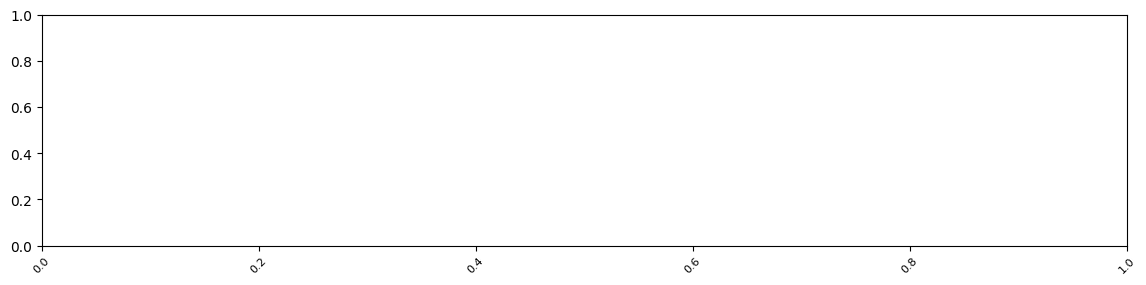

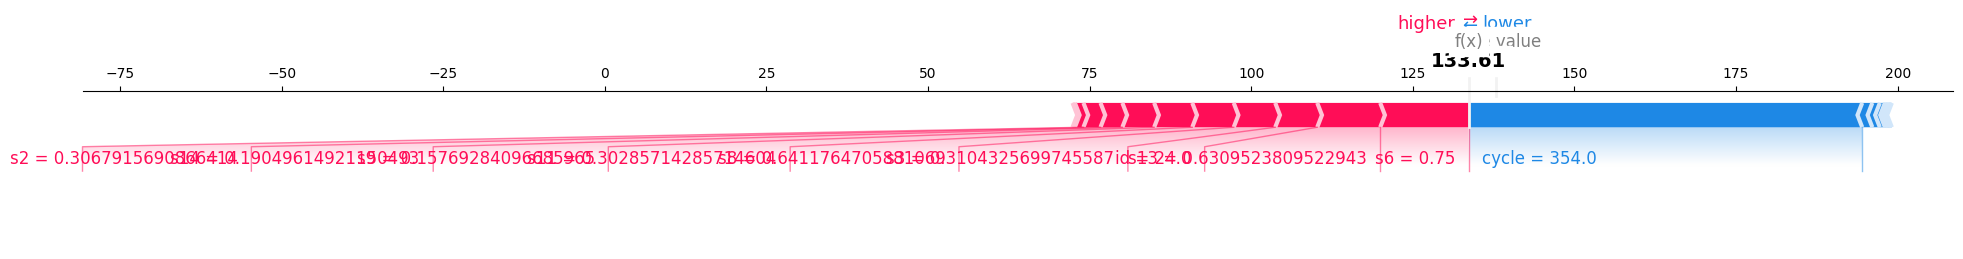

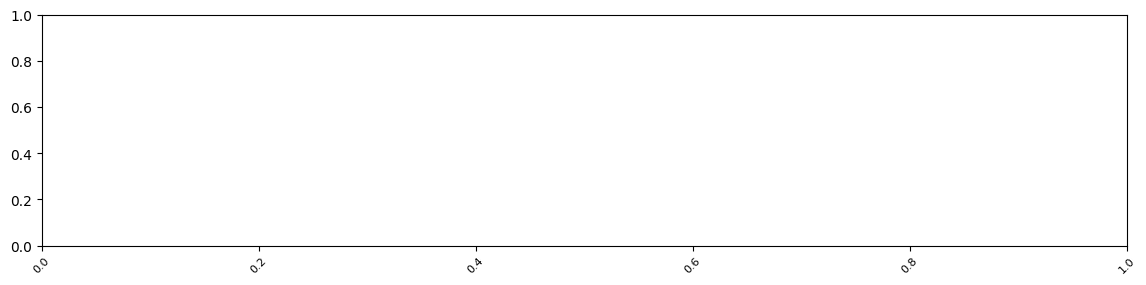

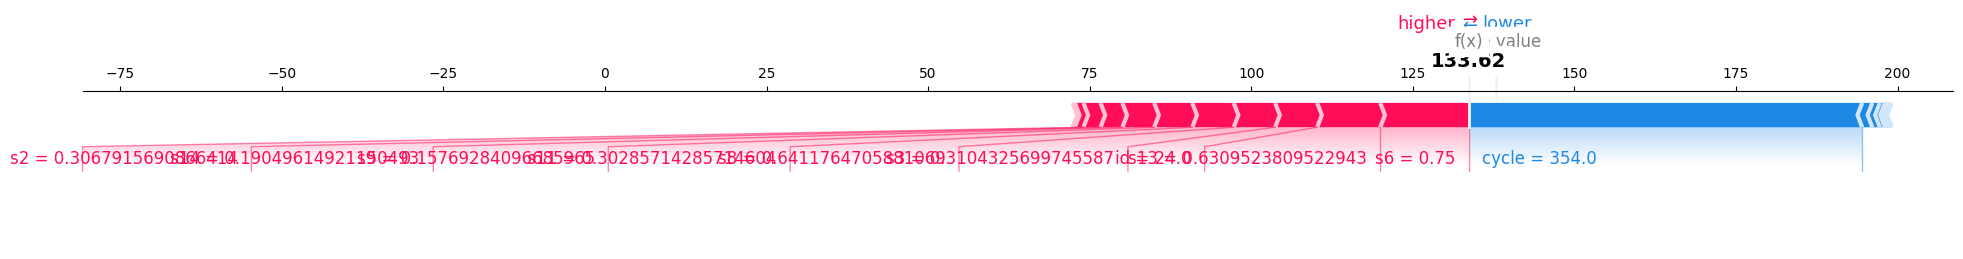

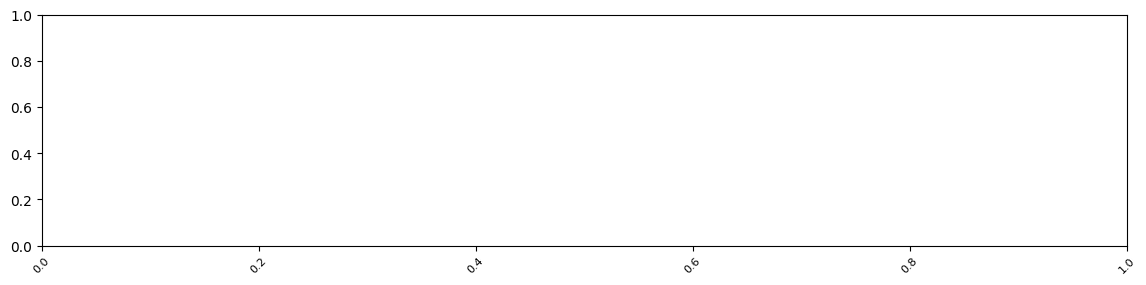

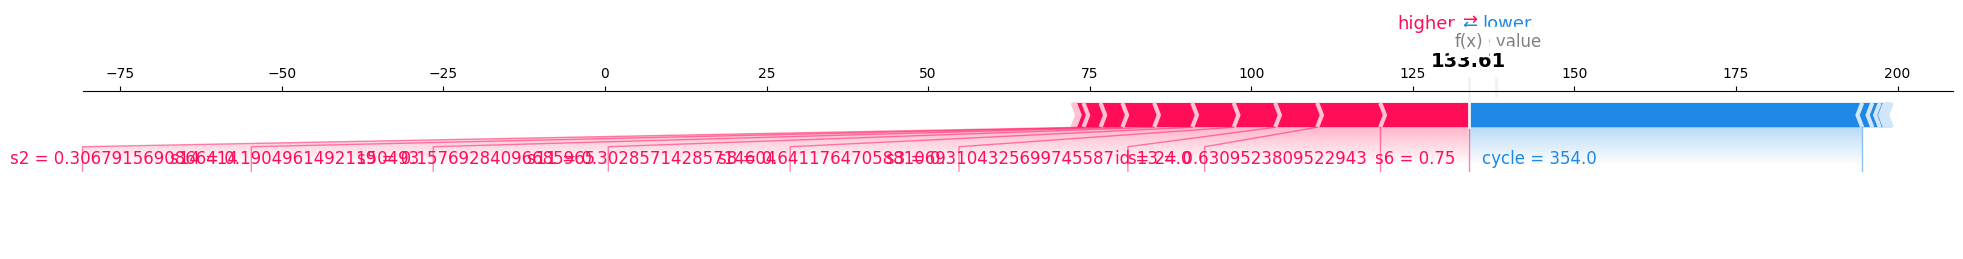

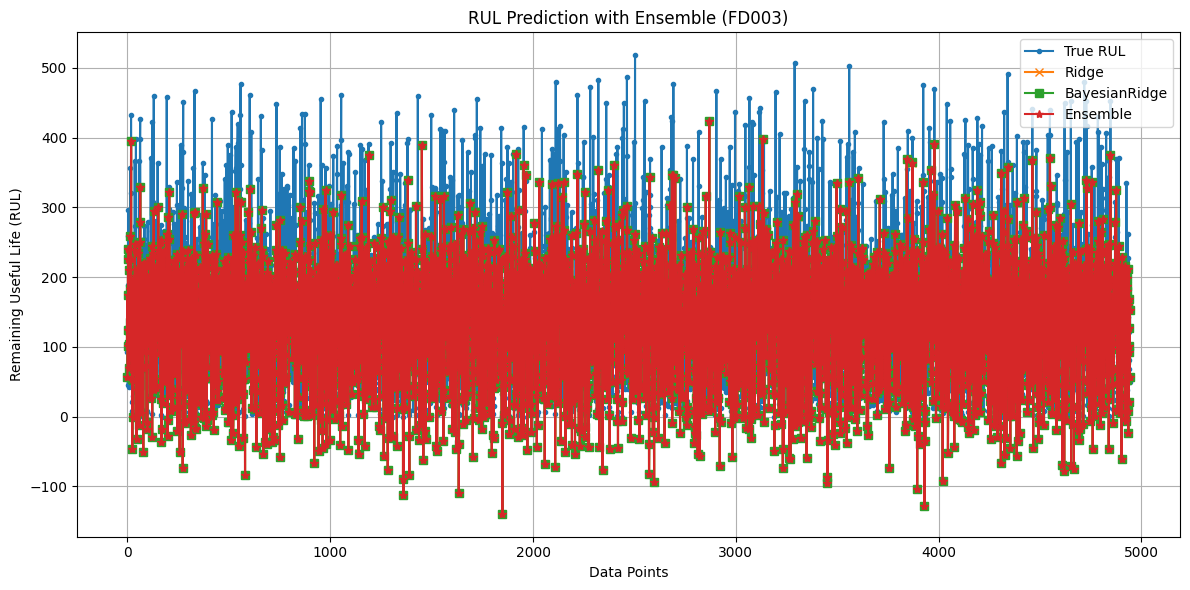



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (Ridge) ---
Fold1: R2=0.5446, RMSE=68.3702, MAE=52.7019, PHM08_sum=8166479641.0552, PHM08_avg=1652464.5166
Fold2: R2=0.6850, RMSE=55.3714, MAE=40.8878, PHM08_sum=407263002.5690, PHM08_avg=82341.8930
Fold3: R2=0.5029, RMSE=69.3378, MAE=49.8674, PHM08_sum=57679638186.2048, PHM08_avg=11661875.8969
Fold4: R2=0.6394, RMSE=58.9394, MAE=45.3778, PHM08_sum=860501734.5894, PHM08_avg=174190.6345
Fold5: R2=0.6095, RMSE=61.0629, MAE=44.2298, PHM08_sum=30531500336877.9141, PHM08_avg=6172968123.1051
Overall: R2=0.5957, RMSE=62.8502, MAE=46.6122, PHM08_sum=30598614219442.3359, PHM08_avg=1237808018.5859

--- GroupKFold (BayesianRidge) ---
Fold1: R2=0.5445, RMSE=68.3723, MAE=52.7055, PHM08_sum=8391393618.2601, PHM08_avg=1697975.2364
Fold2: R2=0.6850, RMSE=55.3689, MAE=4

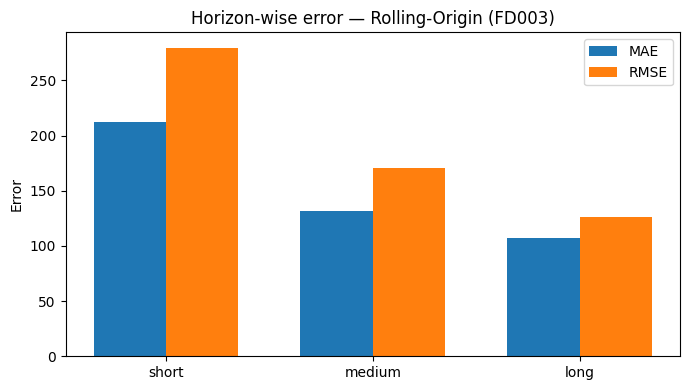


[PER-ENGINE MAE] (Top 10 worst engines)
7     259.654214
55    253.562204
96    245.369890
27    226.469569
34    224.251267
94    216.519394
81    212.635273
9     208.966211
20    208.529866
39    208.316743
dtype: float64


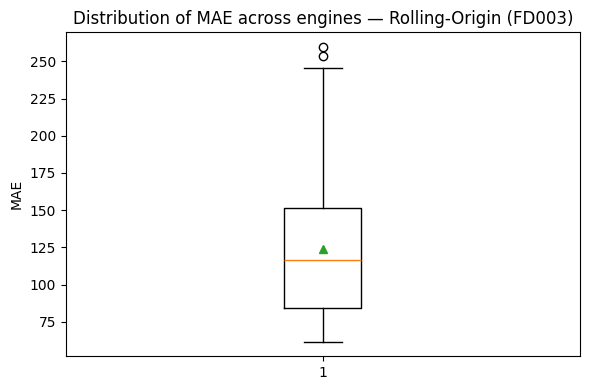


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -8.1991
    RMSE: 190.7013
     MAE: 142.4599
 sMAPE_%: 114.6019

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.5963 ± 0.0653
Without id/cycle : R²=0.5790 ± 0.0319



================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 24720
Train (80%)   : 19776  → ratio=0.8000
Test  (20%)   : 4944  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 39.21 seconds
CPU% at start        : 3.6%   (~0.09 GHz)
CPU% at end          : 38.9%   (~1.01 GHz)
Memory at start      : 574.68 MB
Memory at end        : 574.95 MB   (Δ 0.26 MB)


In [6]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD003"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "ridgeregbayesridge"

# Fixed model hyperparameters (as requested)
RIDGE_PARAMS = dict(
    alpha=1.0,
    max_iter=1000,
    solver='auto',
    random_state=42
)

BAYES_PARAMS = dict(
    alpha_1=1e-6,
    alpha_2=1e-5,
    lambda_1=1e-4,
    lambda_2=1e-6,
    tol=1e-4
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.linear_model import Ridge, BayesianRidge

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (Ridge + BayesianRidge)
# ============================================
ridge_model = Ridge(**RIDGE_PARAMS)
ridge_model.fit(X_train, y_train)
y_ridge = ridge_model.predict(X_val)

bayes_model = BayesianRidge(**BAYES_PARAMS)
bayes_model.fit(X_train, y_train)
y_bayes = bayes_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_ridge + 0.5 * y_bayes

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_ridge = print_block_metrics("Ridge",        y_val, y_ridge)
m_bayes = print_block_metrics("BayesianRidge",y_val, y_bayes)
m_ens   = print_block_metrics("Ensemble",     y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_ridge, m_bayes, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (modern API for linear models)
# ============================================
import shap
from shap import maskers

n_samples = min(1000, X_val.shape[0])
X_shap = X_val.sample(n=n_samples, random_state=42)

# Build a masker from the training data (independent perturbation)
mask = maskers.Independent(X_train)

# Ridge SHAP
explainer_ridge = shap.LinearExplainer(ridge_model, mask)
ridge_exp = explainer_ridge(X_shap)          # Explanation object
shap_vals_ridge = ridge_exp.values           # (n_samples, n_features)
expected_ridge = np.atleast_1d(ridge_exp.base_values).mean()

print("Plotting SHAP summary (Ridge)...")
shap.summary_plot(shap_vals_ridge, X_shap, show=False)
plt.title(f"SHAP Summary — Ridge ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ridge_{DATASET_NAME}.png")
plt.show()

# BayesianRidge SHAP
explainer_bayes = shap.LinearExplainer(bayes_model, mask)
bayes_exp = explainer_bayes(X_shap)
shap_vals_bayes = bayes_exp.values
expected_bayes = np.atleast_1d(bayes_exp.base_values).mean()

print("Plotting SHAP summary (BayesianRidge)...")
shap.summary_plot(shap_vals_bayes, X_shap, show=False)
plt.title(f"SHAP Summary — BayesianRidge ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_BayesianRidge_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP (average the per-feature contributions)
shap_vals_ens = (shap_vals_ridge + shap_vals_bayes) / 2.0
print("Plotting SHAP summary (Ensemble)...")
shap.summary_plot(shap_vals_ens, X_shap, show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# ---------- Local (single-row) force plots ----------
row = X_shap.iloc[[0]]

ridge_row_exp = explainer_ridge(row)
sv_ridge_row  = ridge_row_exp.values[0]
base_ridge    = float(np.atleast_1d(ridge_row_exp.base_values)[0])

bayes_row_exp = explainer_bayes(row)
sv_bayes_row  = bayes_row_exp.values[0]
base_bayes    = float(np.atleast_1d(bayes_row_exp.base_values)[0])

sv_ens_row    = (sv_ridge_row + sv_bayes_row) / 2.0
base_ens      = (base_ridge + base_bayes) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_ridge, sv_ridge_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ridge_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_bayes, sv_bayes_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_BayesianRidge_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_ens, sv_ens_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_ridge)),    y_ridge,        label="Ridge",           marker='x')
plt.plot(range(len(y_bayes)),    y_bayes,        label="BayesianRidge",   marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",        marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_ridge = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", Ridge(**RIDGE_PARAMS))
])
pipe_bayes = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", BayesianRidge(**BAYES_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_ridge, name="Ridge")
_ = cv_eval_pipeline(X, y, groups, pipe_bayes, name="BayesianRidge")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_ridge():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])

def build_pipe_bayes():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", BayesianRidge(**BAYES_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge, name="Ridge"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_bayes, name="BayesianRidge"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_ridge, name="Ridge")
_ = cv_eval_pipeline(X, y, groups, build_pipe_ridge(), name="Ridge (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge,
    embargo_val=0,  name=f"Rolling-Origin Ridge (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge,
    embargo_val=10, name=f"Rolling-Origin Ridge (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_ridge)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_ridge)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



Ridge Performance:
  R^2 Score:           0.6103
  Mean Squared Error:  3133.3167
  Mean Absolute Error: 42.9137
  PHM08 Score (sum):   310492415795.8184
  PHM08 Score (avg):   25346319.6568

BayesianRidge Performance:
  R^2 Score:           0.6126
  Mean Squared Error:  3114.7881
  Mean Absolute Error: 42.7432
  PHM08 Score (sum):   277381275054.9545
  PHM08 Score (avg):   22643369.3922

Ensemble Performance:
  R^2 Score:           0.6121
  Mean Squared Error:  3119.1816
  Mean Absolute Error: 42.7878
  PHM08 Score (sum):   291970344722.1562
  PHM08 Score (avg):   23834313.8549
Plotting SHAP summary (Ridge)...


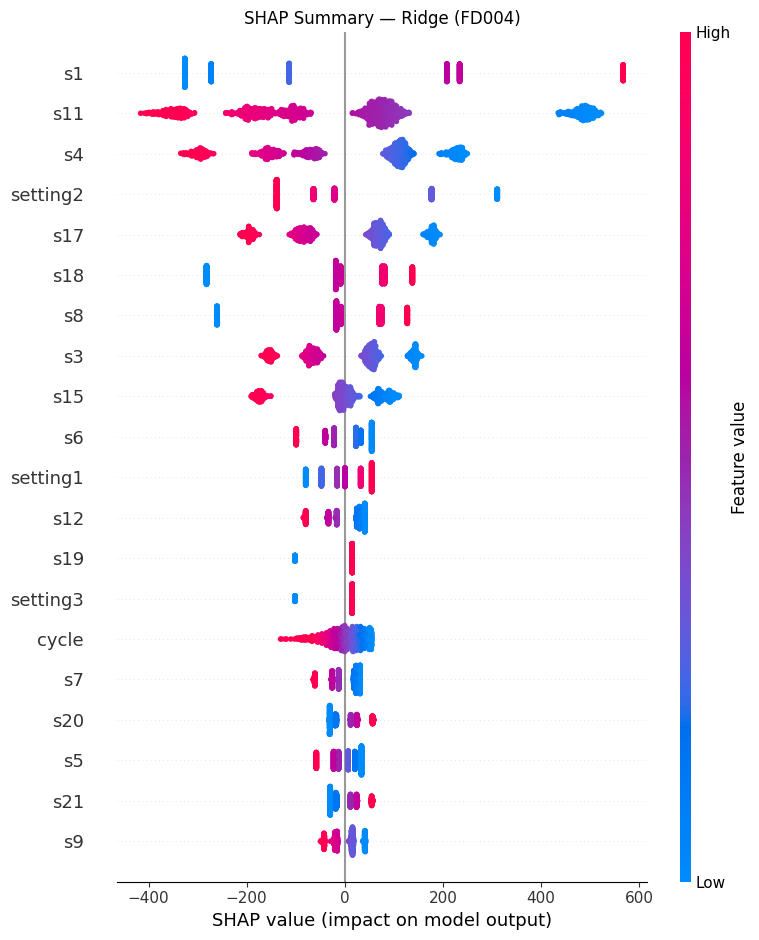

Plotting SHAP summary (BayesianRidge)...


Plotting SHAP summary (Ensemble)...


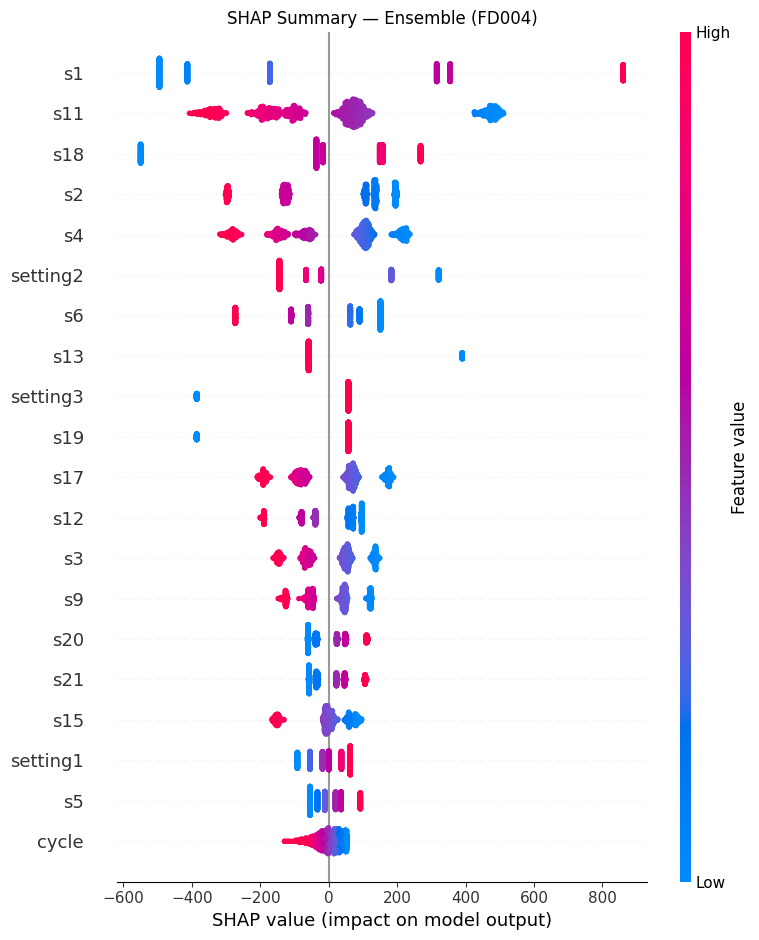

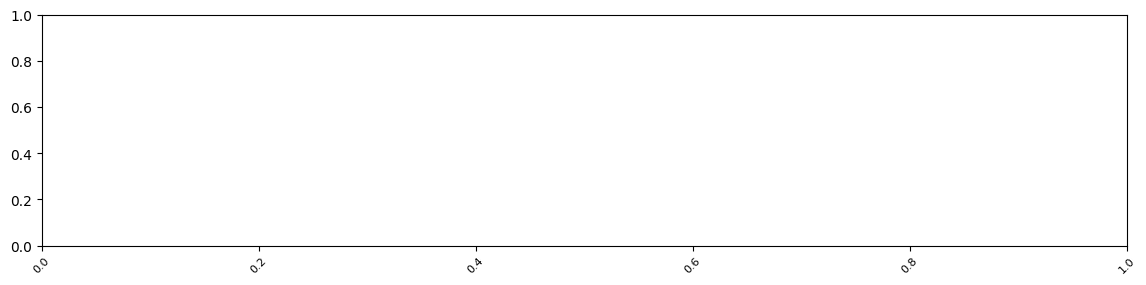

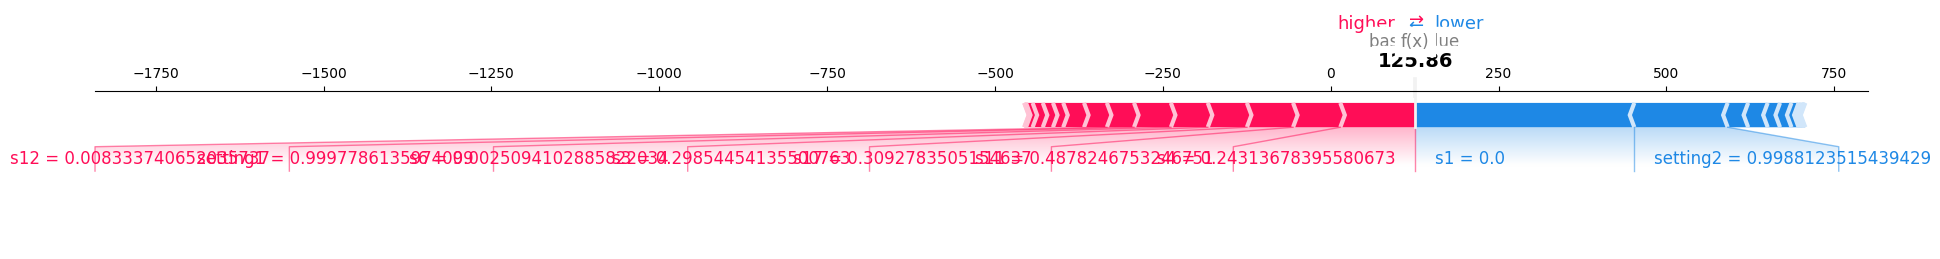

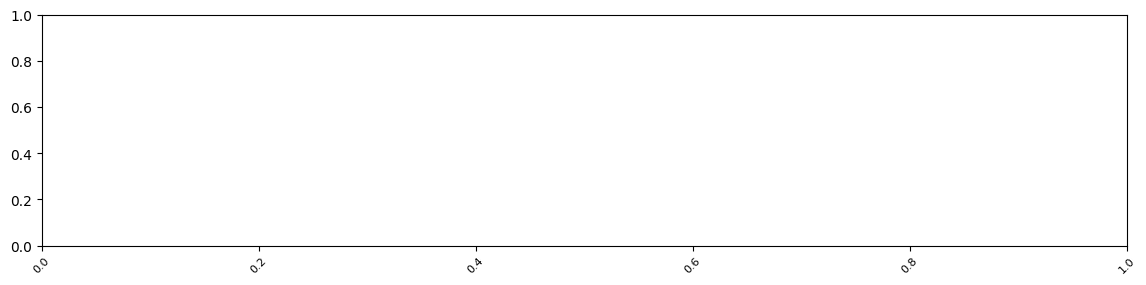

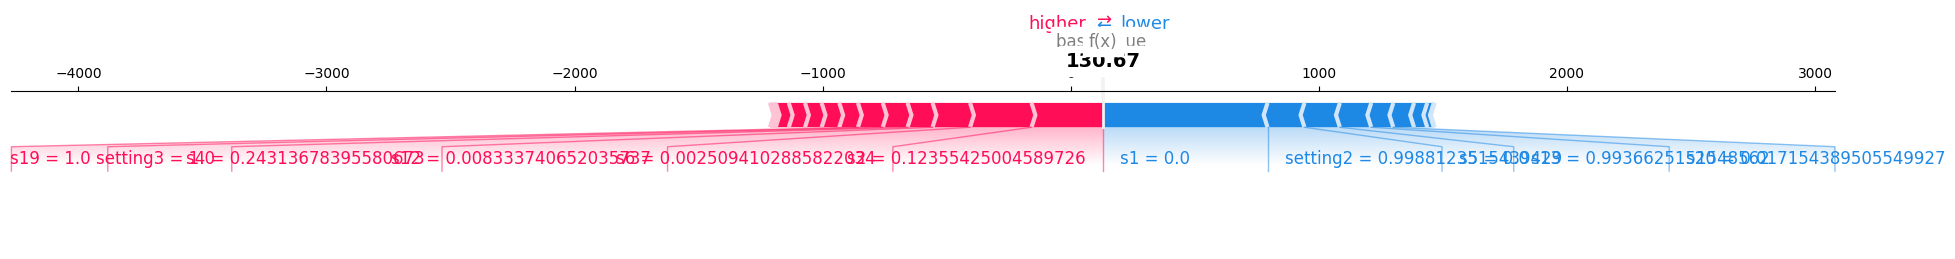

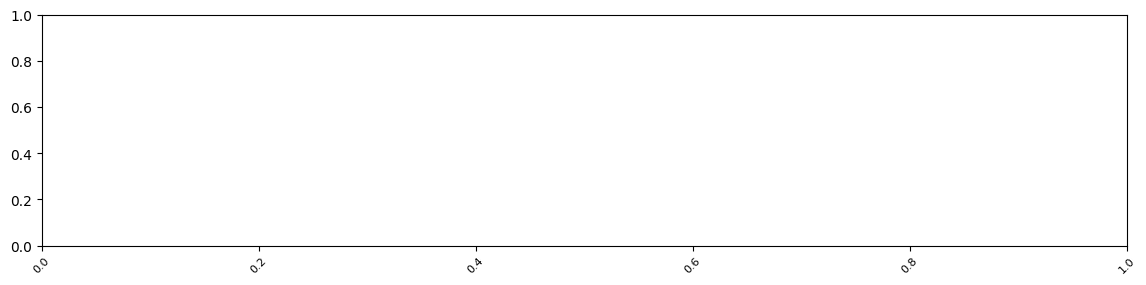

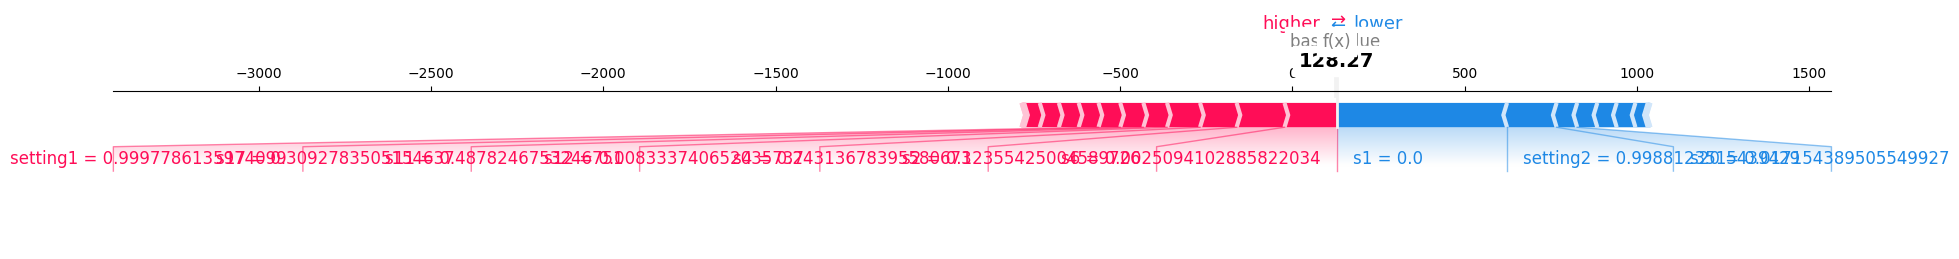

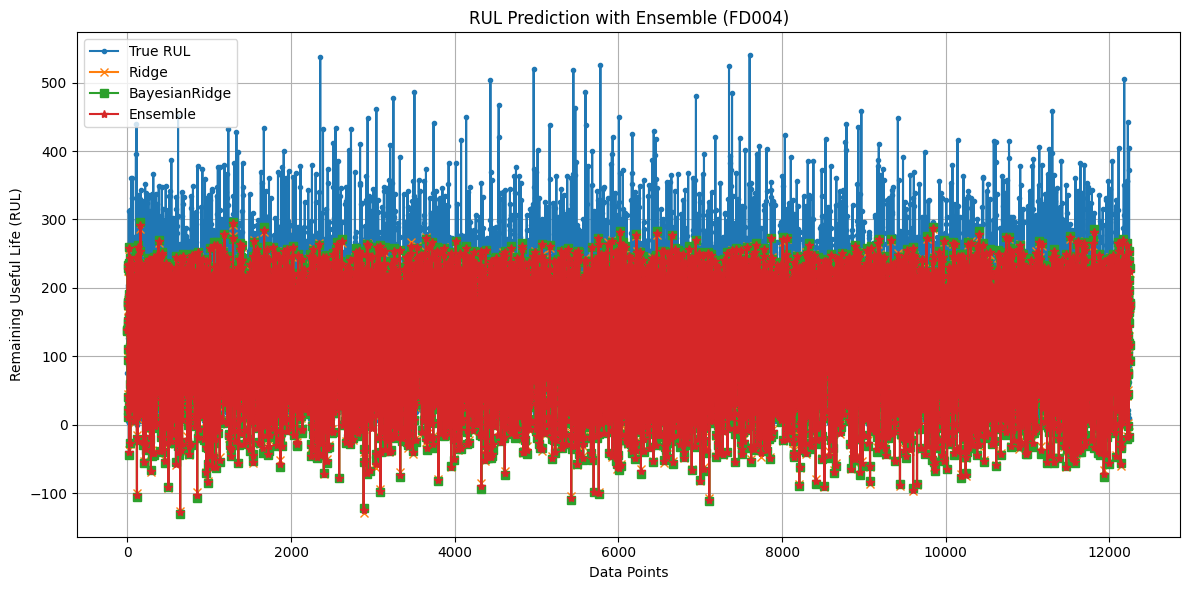



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (Ridge) ---
Fold1: R2=0.5190, RMSE=64.3315, MAE=47.6114, PHM08_sum=1320723294707.8701, PHM08_avg=107550756.8980
Fold2: R2=0.6432, RMSE=53.7080, MAE=40.9155, PHM08_sum=6622128092.5232, PHM08_avg=545210.6119
Fold3: R2=0.6052, RMSE=55.8564, MAE=44.2067, PHM08_sum=467508714.3590, PHM08_avg=38092.4562
Fold4: R2=0.6355, RMSE=53.5169, MAE=41.4940, PHM08_sum=678242373.6901, PHM08_avg=55258.4629
Fold5: R2=0.6389, RMSE=53.2520, MAE=41.0276, PHM08_sum=348601332.6964, PHM08_avg=28396.9805
Overall: R2=0.6068, RMSE=56.2961, MAE=43.0559, PHM08_sum=1328839775221.1389, PHM08_avg=21695697.4844

--- GroupKFold (BayesianRidge) ---
Fold1: R2=0.5175, RMSE=64.4315, MAE=47.7307, PHM08_sum=1207434731035.4414, PHM08_avg=98325303.8302
Fold2: R2=0.6470, RMSE=53.4213, MAE=40.7088, 

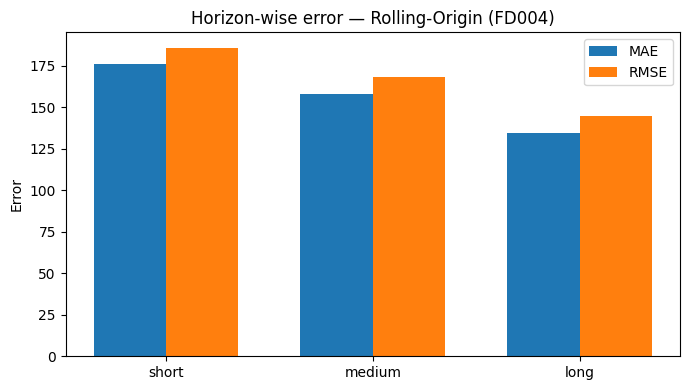

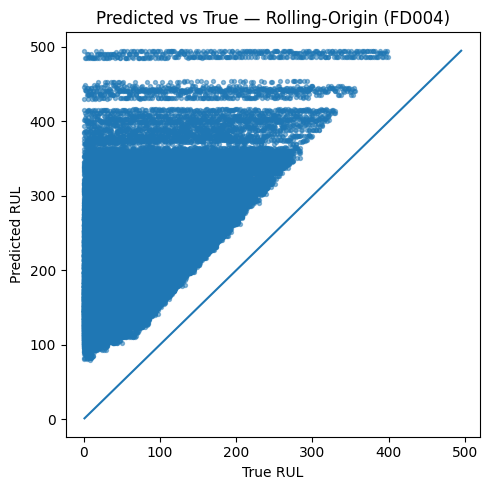


[PER-ENGINE MAE] (Top 10 worst engines)
118    284.457217
133    254.742019
173    242.521378
49     237.320332
179    231.897267
225    222.641657
158    216.739055
171    215.772988
37     210.127976
88     208.526999
dtype: float64


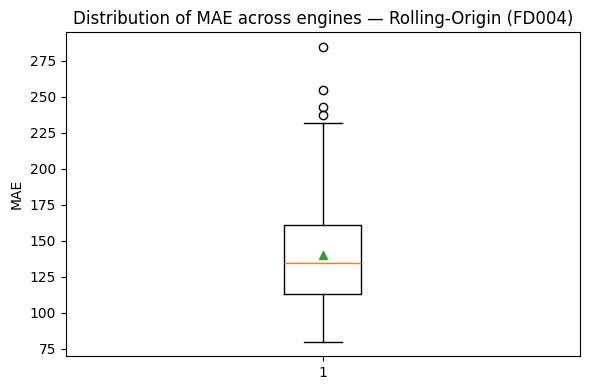

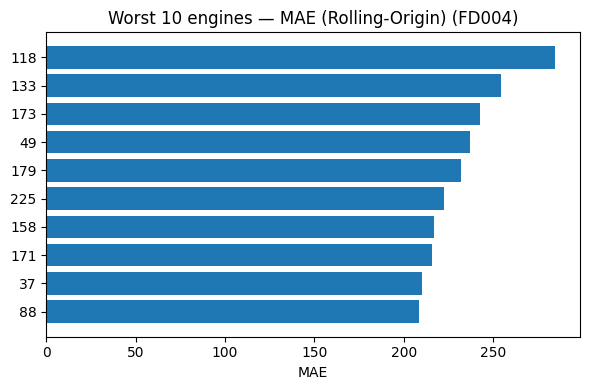


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -7.5819
    RMSE: 164.6683
     MAE: 153.6646
 sMAPE_%: 115.4612

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6084 ± 0.0466
Without id/cycle : R²=0.5283 ± 0.0343


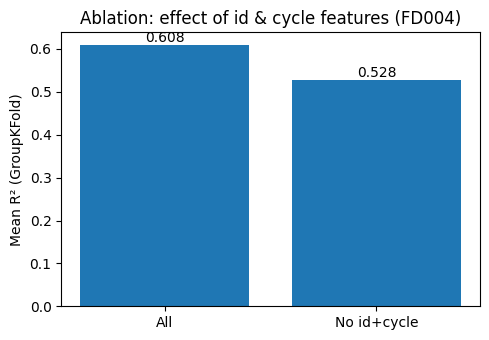


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 61249
Train (80%)   : 48999  → ratio=0.8000
Test  (20%)   : 12250  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 83.05 seconds
CPU% at start        : 13.9%   (~0.36 GHz)
CPU% at end          : 18.1%   (~0.47 GHz)
Memory at start      : 575.20 MB
Memory at end        : 592.52 MB   (Δ 17.32 MB)


In [7]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD004"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "ridgeregbayesridge"

# Fixed model hyperparameters (as requested)
RIDGE_PARAMS = dict(
    alpha=1.0,
    max_iter=1000,
    solver='auto',
    random_state=42
)

BAYES_PARAMS = dict(
    alpha_1=1e-6,
    alpha_2=1e-5,
    lambda_1=1e-4,
    lambda_2=1e-6,
    tol=1e-4
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.linear_model import Ridge, BayesianRidge

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (Ridge + BayesianRidge)
# ============================================
ridge_model = Ridge(**RIDGE_PARAMS)
ridge_model.fit(X_train, y_train)
y_ridge = ridge_model.predict(X_val)

bayes_model = BayesianRidge(**BAYES_PARAMS)
bayes_model.fit(X_train, y_train)
y_bayes = bayes_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_ridge + 0.5 * y_bayes

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_ridge = print_block_metrics("Ridge",        y_val, y_ridge)
m_bayes = print_block_metrics("BayesianRidge",y_val, y_bayes)
m_ens   = print_block_metrics("Ensemble",     y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_ridge, m_bayes, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (modern API for linear models)
# ============================================
import shap
from shap import maskers

n_samples = min(1000, X_val.shape[0])
X_shap = X_val.sample(n=n_samples, random_state=42)

# Build a masker from the training data (independent perturbation)
mask = maskers.Independent(X_train)

# Ridge SHAP
explainer_ridge = shap.LinearExplainer(ridge_model, mask)
ridge_exp = explainer_ridge(X_shap)          # Explanation object
shap_vals_ridge = ridge_exp.values           # (n_samples, n_features)
expected_ridge = np.atleast_1d(ridge_exp.base_values).mean()

print("Plotting SHAP summary (Ridge)...")
shap.summary_plot(shap_vals_ridge, X_shap, show=False)
plt.title(f"SHAP Summary — Ridge ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ridge_{DATASET_NAME}.png")
plt.show()

# BayesianRidge SHAP
explainer_bayes = shap.LinearExplainer(bayes_model, mask)
bayes_exp = explainer_bayes(X_shap)
shap_vals_bayes = bayes_exp.values
expected_bayes = np.atleast_1d(bayes_exp.base_values).mean()

print("Plotting SHAP summary (BayesianRidge)...")
shap.summary_plot(shap_vals_bayes, X_shap, show=False)
plt.title(f"SHAP Summary — BayesianRidge ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_BayesianRidge_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP (average the per-feature contributions)
shap_vals_ens = (shap_vals_ridge + shap_vals_bayes) / 2.0
print("Plotting SHAP summary (Ensemble)...")
shap.summary_plot(shap_vals_ens, X_shap, show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# ---------- Local (single-row) force plots ----------
row = X_shap.iloc[[0]]

ridge_row_exp = explainer_ridge(row)
sv_ridge_row  = ridge_row_exp.values[0]
base_ridge    = float(np.atleast_1d(ridge_row_exp.base_values)[0])

bayes_row_exp = explainer_bayes(row)
sv_bayes_row  = bayes_row_exp.values[0]
base_bayes    = float(np.atleast_1d(bayes_row_exp.base_values)[0])

sv_ens_row    = (sv_ridge_row + sv_bayes_row) / 2.0
base_ens      = (base_ridge + base_bayes) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_ridge, sv_ridge_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ridge_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_bayes, sv_bayes_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_BayesianRidge_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(base_ens, sv_ens_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_ridge)),    y_ridge,        label="Ridge",           marker='x')
plt.plot(range(len(y_bayes)),    y_bayes,        label="BayesianRidge",   marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",        marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_ridge = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", Ridge(**RIDGE_PARAMS))
])
pipe_bayes = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", BayesianRidge(**BAYES_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_ridge, name="Ridge")
_ = cv_eval_pipeline(X, y, groups, pipe_bayes, name="BayesianRidge")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_ridge():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])

def build_pipe_bayes():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", BayesianRidge(**BAYES_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge, name="Ridge"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_bayes, name="BayesianRidge"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", Ridge(**RIDGE_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_ridge, name="Ridge")
_ = cv_eval_pipeline(X, y, groups, build_pipe_ridge(), name="Ridge (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge,
    embargo_val=0,  name=f"Rolling-Origin Ridge (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge,
    embargo_val=10, name=f"Rolling-Origin Ridge (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_ridge
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_ridge)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_ridge)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")
